<a href="https://colab.research.google.com/github/fahad-30/Poisson_DON/blob/main/Poisson_DeepONet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We are using data from the paper:
https://arxiv.org/abs/2503.05598

The 2D domain is: (0,1)x(0,1)

The domain discretised using 50 elements along each axis

we are solving the following equation:

<center>



 $-\nabla \cdot (m(x) \nabla u(x)) = f(x) , \quad ∀ x \in D_u$

 $u(x) = 0 , \quad ∀ x \in \Gamma_{u_d}$

 $m(x)\nabla u(x) \cdot n(x) = q(x) , \quad ∀ x \in \Gamma_{u_n}$

 $ f(x) = 1000(1-x_2)x_2(1-x_1)^2 $

 $q(x) = 50 sin (5\pi x_2)$

</center>

u is temperature and m is diffusivity. m is a positivie random funcition



## Import Librariries

In [8]:
import sys
import os

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset,DataLoader
# DataLoader
import numpy as np
import time


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

## Data Utils

### Data Handler

In [9]:

class DataHandler(Dataset):

    def __init__(self, X_train_, X_trunk_, Y_train_, \
                 convert_to_tensor=True):

        self.X_train = self.convert_np_to_tensor(X_train_) if convert_to_tensor else X_train_

        if X_trunk_ is None:
            self.X_trunk = None
        else:
            self.X_trunk = self.convert_np_to_tensor(X_trunk_) if convert_to_tensor else X_trunk_

        self.Y_train = self.convert_np_to_tensor(Y_train_) if convert_to_tensor else Y_train_

    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array

    def __len__(self):
        return len(self.Y_train)

    def __getitem__(self, index):
        if self.X_trunk is None:
            return self.X_train[index,:], self.Y_train[index,:]
        else:
            return self.X_train[index,:], self.X_trunk, self.Y_train[index,:]


### Data Processor

In [10]:
class DataProcessor:

    def __init__(self, data_file_name, \
                 num_train = 1900, num_test = 100, \
                 num_inp_fn_points = 2601, num_out_fn_points = 2601, \
                 num_Y_components = 1, \
                 num_inp_red_dim = None, \
                 num_out_red_dim = None):

        # load data from file
        self.data = np.load(data_file_name)

        self.num_train = num_train
        self.num_test = num_test
        self.num_inp_fn_points = num_inp_fn_points
        self.num_out_fn_points = num_out_fn_points
        self.num_Y_components = num_Y_components
        self.num_inp_red_dim = num_inp_red_dim
        self.num_out_red_dim = num_out_red_dim
        self.tol = 1.0e-9

        self.load_X_data(self.data)
        self.load_Y_data(self.data)

    def get_data_to_save(self):
        data_to_save = {}
        data_to_save['num_train'] = self.num_train
        data_to_save['num_test'] = self.num_test
        data_to_save['num_inp_fn_points'] = self.num_inp_fn_points
        data_to_save['num_out_fn_points'] = self.num_out_fn_points
        data_to_save['num_Y_components'] = self.num_Y_components
        data_to_save['num_inp_red_dim'] = self.num_inp_red_dim
        data_to_save['num_out_red_dim'] = self.num_out_red_dim

        data_to_save['X_trunk'] = self.X_trunk
        data_to_save['X_trunk_min'] = self.X_trunk_min
        data_to_save['X_trunk_max'] = self.X_trunk_max
        data_to_save['X_train'] = self.X_train
        data_to_save['X_test'] = self.X_test
        data_to_save['X_train_mean'] = self.X_train_mean
        data_to_save['X_train_std'] = self.X_train_std
        data_to_save['X_train_svd_projector'] = self.X_train_svd_projector
        data_to_save['X_train_s_values'] = self.X_train_s_values
        data_to_save['Y_train'] = self.Y_train
        data_to_save['Y_test'] = self.Y_test
        data_to_save['Y_train_mean'] = self.Y_train_mean
        data_to_save['Y_train_std'] = self.Y_train_std
        data_to_save['Y_train_svd_projector'] = self.Y_train_svd_projector
        data_to_save['Y_train_s_values'] = self.Y_train_s_values
        data_to_save['u_mesh_dirichlet_boundary_nodes'] = self.u_mesh_dirichlet_boundary_nodes
        return data_to_save

    def load_X_data(self, data):

        # trunk input data ('xi' coordinates)
        self.X_trunk = data['u_mesh_nodes']
        self.X_trunk_min = np.min(self.X_trunk, axis = 0)
        self.X_trunk_max = np.max(self.X_trunk, axis = 0)

        # branch input data ('m' functions)
        self.X_train = data['m_samples'][:self.num_train,:]
        self.X_test = data['m_samples'][self.num_train:(self.num_train + self.num_test),:]

        self.X_train_mean = np.mean(self.X_train, 0)
        self.X_train_std = np.std(self.X_train, 0)

        self.X_train = (self.X_train - self.X_train_mean)/(self.X_train_std + self.tol)
        self.X_test = (self.X_test - self.X_train_mean)/(self.X_train_std + self.tol)

        if self.num_inp_red_dim is not None:
            # compute SVD of input data
            self.X_train_svd_projector, self.X_train_s_values = self.compute_svd(self.X_train, self.num_inp_red_dim, is_data_centered = True)

            # define training and testing data in the reduced dimension
            self.X_train = np.dot(self.X_train, self.X_train_svd_projector.T)
            self.X_test = np.dot(self.X_test, self.X_train_svd_projector.T)
        else:
            self.X_train_svd_projector = None
            self.X_train_s_values = None

    def load_Y_data(self, data):

        # output data ('u' functions)
        self.Y_train = data['u_samples'][:self.num_train,:]
        self.Y_test = data['u_samples'][self.num_train:(self.num_train + self.num_test),:]

        if self.num_out_fn_points * self.num_Y_components != self.Y_train.shape[1]:
            raise ValueError('num_out_fn_points does not match the number of output function points in the data')

        self.Y_train_mean = np.mean(self.Y_train, 0)
        self.Y_train_std = np.std(self.Y_train, 0)

        self.Y_train = (self.Y_train - self.Y_train_mean)/(self.Y_train_std + self.tol)
        self.Y_test = (self.Y_test - self.Y_train_mean)/(self.Y_train_std + self.tol)

        if self.num_out_red_dim is not None:
            # compute SVD of output data
            self.Y_train_svd_projector, self.Y_train_s_values = self.compute_svd(self.Y_train, self.num_out_red_dim, is_data_centered = True)

            # define training and testing data in the reduced dimension
            self.Y_train = np.dot(self.Y_train, self.Y_train_svd_projector.T)
            self.Y_test = np.dot(self.Y_test, self.Y_train_svd_projector.T)
        else:
            self.Y_train_svd_projector = None
            self.Y_train_s_values = None

        # read indices corresponding to the Dirichlet boundary conditions
        self.u_mesh_dirichlet_boundary_nodes = data['u_mesh_dirichlet_boundary_nodes']

    def encoder_Y(self, x):
        x = (x - self.Y_train_mean)/(self.Y_train_std + self.tol)
        if self.Y_train_svd_projector is not None:
            return self.project_SVD(x, self.Y_train_svd_projector)
        else:
            return x

    def decoder_Y(self, x):
        # first lift the data to the original dimension
        if self.Y_train_svd_projector is not None:
            x = self.lift_SVD(x, self.Y_train_svd_projector)

        x = x*(self.Y_train_std + self.tol) + self.Y_train_mean
        return x

    def encoder_X(self, x):
        x = (x - self.X_train_mean)/(self.X_train_std + self.tol)
        if self.X_train_svd_projector is not None:
            return self.project_SVD(x, self.X_train_svd_projector)
        else:
            return x

    def decoder_X(self, x):
        # first lift the data to the original dimension
        if self.X_train_svd_projector is not None:
            x = self.lift_SVD(x, self.X_train_svd_projector)

        x = x*(self.X_train_std + self.tol) + self.X_train_mean
        return x

    def compute_svd(self, data, num_red_dim, is_data_centered = False):
        if is_data_centered == False:
            data_mean = np.mean(data, 0)
            data = data - data_mean
        U, S, _ = np.linalg.svd(data.T, full_matrices = False)
        projector = U[:, :num_red_dim].T # size num_red_dim x dim(X_train[0])
        return projector, S

    def project_SVD(self, data, Pi):
        return np.dot(data, Pi.T)

    def lift_SVD(self, data, Pi):
        return np.dot(data, Pi)


## Define Data

In [17]:
import gdown


file_id = "1NyvEDtqpb1Wc8w-cQNcVzZo1fv41Q0Qd"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "Poisson_data.npz", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1NyvEDtqpb1Wc8w-cQNcVzZo1fv41Q0Qd
From (redirected): https://drive.google.com/uc?id=1NyvEDtqpb1Wc8w-cQNcVzZo1fv41Q0Qd&confirm=t&uuid=f8a8ae14-3ae8-42a6-bb64-31a65c1397cb
To: /content/Poisson_data.npz
100%|██████████| 475M/475M [00:05<00:00, 79.3MB/s]


'Poisson_data.npz'

In [19]:


current_directory = os.getcwd()
results_dir = current_directory+'/Results/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

num_train = 3500
num_test = 1000

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_Y_components = 1 # scalar field
num_tr_outputs = 100 # number of outputs from the trunk network before they are multiplied
num_br_outputs = 100 # number of outputs from the branch and trunk networks before they are multiplied
out_coordinate_dimension = 2 # domain for output function is 2D


# training hyperparameters
batch_size = 20
epochs = 1000
lr = 1.0e-3
act_fn = torch.relu

data = DataProcessor("/content/Poisson_data.npz", num_train, num_test, num_inp_fn_points, num_out_fn_points, num_Y_components)

train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

# get data to save so that we can use the same data with other neural operators
data_to_save = data.get_data_to_save()

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

X_train: (3500, 2601)
Y_train: (3500, 2601)
X_test: (1000, 2601)
Y_test: (1000, 2601)
X_trunk: (2601, 2)


## MLP and DeepONet

In [20]:
class MLP(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes, depth, act):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.act = act

        # input layer
        self.layers.append(nn.Linear(input_size, hidden_size))

        # hidden layers
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        # output layer
        self.layers.append(nn.Linear(hidden_size, num_classes))

    def forward(self, x, final_act=False):
        for i in range(len(self.layers) - 1):
            x = self.act(self.layers[i](x))

        # last layer
        x = self.layers[-1](x)
        if final_act == False:
            return x
        else:
            return torch.relu(x)
class DeepONet(nn.Module):

    def __init__(self, num_layers, num_neurons, act, \
                 num_br_outputs, num_tr_outputs, \
                 num_inp_fn_points, \
                 out_coordinate_dimension, \
                 num_Y_components, save_file=None):

        super(DeepONet, self).__init__()
        self.name = 'DeepONet'

        self.num_inp_fn_points = num_inp_fn_points
        self.num_br_outputs = num_br_outputs
        self.num_tr_outputs = num_tr_outputs
        self.out_coordinate_dimension = out_coordinate_dimension
        self.num_Y_components = num_Y_components
        self.save_file = save_file
        if save_file is None:
            self.save_file = './DeepONet_model/model.pkl'

        # branch network
        self.branch_net = MLP(input_size=num_inp_fn_points, \
                              hidden_size=num_neurons, \
                              num_classes=num_br_outputs, \
                              depth=num_layers, \
                              act=act)
        self.branch_net.float()

        # trunk network
        self.trunk_net = MLP(input_size=out_coordinate_dimension, \
                             hidden_size=num_neurons, \
                             num_classes=num_tr_outputs, \
                             depth=num_layers, \
                             act=act)
        self.trunk_net.float()

        # bias added to the product of branch and trunk networks
        self.bias = [nn.Parameter(torch.ones((1,)),requires_grad=True) for i in range(num_Y_components)]

        # dimension d_o of the pointwise value of the target function (u(x) \in R^d_o)
        self.num_Y_components = num_Y_components

        # record losses
        self.train_loss_log = []
        self.test_loss_log = []

        # metadata (used in applications, e.g., bayesian inversion)
        self.metadata = None

    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array

    def forward(self, X, X_trunk):

        X = self.convert_np_to_tensor(X)
        X_trunk = self.convert_np_to_tensor(X_trunk)

        branch_out = self.branch_net.forward(X)
        trunk_out = self.trunk_net.forward(X_trunk,final_act=True)

        if self.num_Y_components == 1:
            output = branch_out @ trunk_out.t() + self.bias[0]
        else:
            # when d_o > 1, split the branch output and compute the product
            output = []
            for i in range(self.num_Y_components):
                output.append(branch_out[:,i*self.num_tr_outputs:(i+1)*self.num_tr_outputs] @ trunk_out.t() + self.bias[i])

            # stack and reshape
            output = torch.stack(output, dim=-1)
            output = output.reshape(-1, X_trunk.shape[0] * self.num_Y_components)

        return output

    def train(self, train_data, test_data, \
              batch_size=32, epochs = 1000, \
              lr=0.001, log=True, \
              loss_print_freq = 100, \
              save_model = False, save_file = None, save_epoch = 100):

        self.epochs = epochs
        self.batch_size = batch_size
        self.save_epoch = save_epoch

        if save_file is not None:
            self.save_file = save_file


        # train and test dataloaders to sample batches of data
        dataset = DataHandler(train_data['X_train'], \
                              train_data['X_trunk'], train_data['Y_train'])
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        test_dataset = DataHandler(test_data['X_train'], \
                                   test_data['X_trunk'], test_data['Y_train'])
        test_dataloader = DataLoader(test_dataset, \
                                     batch_size=batch_size, shuffle=True)

        # store coordinates for trunk network
        X_trunk = dataset.X_trunk

        # loss and optimizer setup
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

        self.train_loss_log = np.zeros((epochs, 1))
        self.test_loss_log = np.zeros((epochs, 1))

        # training and testing loop
        start_time = time.perf_counter()

        self.trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print('-'*50)
        print('Starting training with {} trainable parameters...'.format(self.trainable_params))
        print('-'*50)

        for epoch in range(1, epochs+1):

            train_losses = []
            test_losses = []

            t1 = time.perf_counter()

            # training loop
            for X_train, _, Y_train in dataloader:

                # clear gradients
                optimizer.zero_grad()

                # forward pass through model
                Y_train_pred = self.forward(X_train, X_trunk)

                # compute and save loss
                loss = criterion(Y_train_pred, Y_train)
                train_losses.append(loss.item())

                # backward pass
                loss.backward()

                # update parameters
                optimizer.step()

            # update learning rate
            scheduler.step()

            # testing loop
            with torch.no_grad():
                for X_test, _, Y_test in test_dataloader:

                    # forward pass through model
                    Y_test_pred = self.forward(X_test, X_trunk)

                    # compute and save test loss
                    test_loss = criterion(Y_test_pred, Y_test)
                    test_losses.append(test_loss.item())

            # log losses
            self.train_loss_log[epoch-1, 0] = np.mean(train_losses)
            self.test_loss_log[epoch-1, 0] = np.mean(test_losses)

            # print loss and time
            t2 = time.perf_counter()
            epoch_time = t2 - t1

            if log == True and (epoch % loss_print_freq == 0 or epoch == epochs or epoch == 1):
                print('-'*50)
                print('Epoch: {:5d}, Train Loss (l2 squared): {:.3e}, Test Loss (l2 squared): {:.3e}, Time (sec): {:.3f}'.format(epoch, \
                                    np.mean(self.train_loss_log[epoch-1, 0]), \
                                    np.mean(self.test_loss_log[epoch-1, 0]), \
                                    epoch_time))
                print('-'*50)

            # check if we need to save model parameters
            if save_model == True and (epoch % save_epoch == 0 or epoch == epochs):
                torch.save(self, self.save_file)
                print('-'*50)
                print('Model parameters saved at epoch {}'.format(epoch))
                print('-'*50)

        # print final message
        end_time = time.perf_counter()
        print('-'*50)
        print('Train time: {:.3f}, Epochs: {:5d}, Batch Size: {:5d}, Final Train Loss (l2 squared): {:.3e}, Final Test Loss (l2 squared): {:.3e}'.format(end_time - start_time, \
                    epochs, batch_size, \
                    self.train_loss_log[-1, 0], \
                    self.test_loss_log[-1, 0]))
        print('-'*50)

    def predict(self, X, X_trunk):
        with torch.no_grad():
            return self.forward(X, X_trunk)

## Create a model and train the network

In [22]:
num_layers = 3
num_neurons = 64

model_save_path = results_dir
model_save_file = model_save_path + 'model_' + time.strftime("%d_%m_%y") +"_.pkl"
print(model_save_file)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = DeepONet(num_layers, num_neurons, act_fn, num_br_outputs, \
                 num_tr_outputs, num_inp_fn_points, \
                 out_coordinate_dimension, num_Y_components,\
                 save_file = model_save_file)


trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

/content/Results/model_28_04_25_.pkl
Number of trainable parameters: 188040


## Train the model


In [ ]:
# save the data and info
data_to_save = data.get_data_to_save()
model_metadata = {  'data': data_to_save, \
                    'num_train': num_train, \
                    'num_test': num_test, \
                    'num_inp_fn_points': num_inp_fn_points, \
                    'num_out_fn_points': num_out_fn_points, \
                    'num_Y_components': num_Y_components, \
                    'num_tr_outputs': num_tr_outputs, \
                    'num_br_outputs': num_br_outputs, \
                    'out_coordinate_dimension': out_coordinate_dimension, \
                    'num_layers': num_layers, \
                    'num_neurons': num_neurons, \
                    'epochs': epochs, \
                    'batch_size': batch_size, \
                    'lr': lr}

# attach it to the model
model.metadata = model_metadata


# Uncomment to train the model
model.train(train_data, test_data, batch_size=batch_size, \
            loss_print_freq=5,epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

--------------------------------------------------
Starting training with 188040 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 6.569e-02, Test Loss (l2 squared): 5.427e-02, Time (sec): 4.920
--------------------------------------------------
--------------------------------------------------
Epoch:     5, Train Loss (l2 squared): 5.256e-02, Test Loss (l2 squared): 4.635e-02, Time (sec): 2.622
--------------------------------------------------
--------------------------------------------------
Epoch:    10, Train Loss (l2 squared): 3.838e-02, Test Loss (l2 squared): 4.095e-02, Time (sec): 14.032
--------------------------------------------------


## Load the model and test it

In [ ]:
# load the model
model = torch.load(model_save_file, weights_only=False)

sfname = model_save_file.split(os.path.sep)
print('-'*50)
print('Model loaded from: {}'.format(sfname[-2] + '/' + sfname[-1]))
print('\n' + '-'*50)
print('Model metadata:', model.metadata.keys())
print('\n' + '-'*50)
print('Model:', model)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Anirbit Research/Poisson DON/Poisson data/model_28_04_25_.pkl'

In [ ]:
Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data['X_train'], test_data['X_trunk']).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (1000, 2601), test_pred shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 1.888e-01, Std Loss (rel l2): 6.115e-02


## Plotting the predicted output

We take 4 random test Data and plot real vs pred data

i_plot =   993, error (rel l2): 2.575e-02
i_plot =   859, error (rel l2): 1.612e-02
i_plot =   298, error (rel l2): 1.070e-02
i_plot =   553, error (rel l2): 1.727e-02


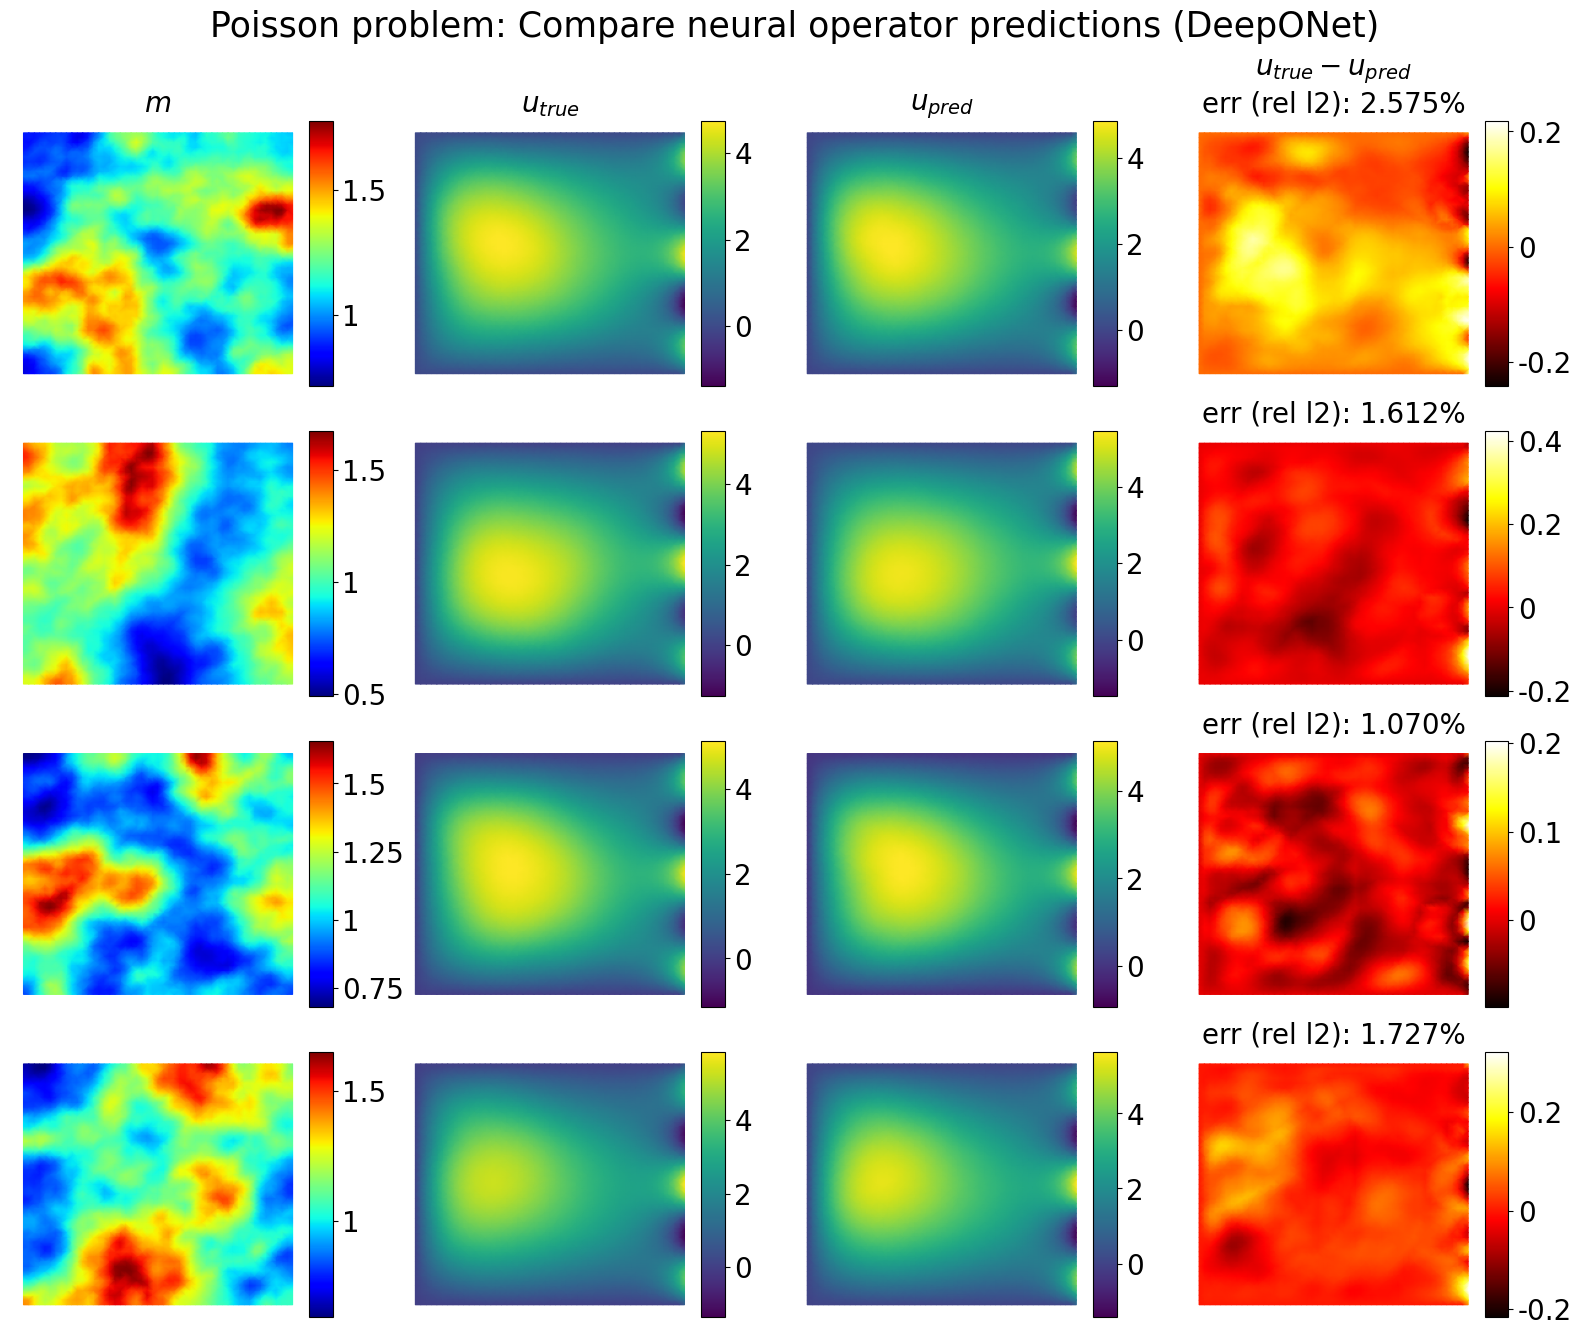

In [ ]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True
apply_dirichlet_bc_flag = True

def apply_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids] = bc_value
    return u

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

nodes = data.X_trunk

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):

    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)
    if apply_dirichlet_bc_flag:
        i_pred = apply_dirichlet_bc(i_pred, 0.0, data.u_mesh_dirichlet_boundary_nodes)
        # verify for i_truth
        if np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max() > 1.0e-9:
            print('Warning: Dirichlet BC not applied to i_truth. Err : {}'.format(np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max()))


    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]

    for j in range(cols):

        cbar = field_plot(axs[i,j], uvec[j], nodes, cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)

            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)

        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Poisson problem: Compare neural operator predictions ({})'.format(model.name), fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()
